# DebyeCalculator - Demo for EPDIC18

**Authors:** Johansen & Anker et. al.

**Questions:** [frjo@di.ku.dk](frjo@di.ku.dk) and [andy@chem.ku.dk](andy@chem.ku.dk)

**Date:** August 2024

---
`DebyeCalculator` is a powerful tool for calculating the scattering intensity $I(Q)$ through the Debye scattering equation, the Total Scattering Structure Function $S(Q)$, the Reduced Total Scattering Function $F(Q)$, and the Reduced Atomic Pair Distribution Function $G(r)$.
This class is optimized to run on GPUs, making it well-suited for large-scale simulations and nanoparticle analysis. It utilizes PyTorch to efficiently perform tensor computations and takes advantage of CUDA acceleration for enhanced speed.

In this notebook, we will demonstrate how to use the `DebyeCalculator` class to calculate scattering for discrete nanoparticles, as well as show some of its many capabilities.

---
Let's get started with an overview of the `DebyeCalculator` class and its main functionalities.

First, import the relavant python packages by running the cell below

In [1]:
# The calculator class
from debyecalculator import DebyeCalculator

# Some classes for storing and visualising
import torch
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import time

---
## Creating an Instance of DebyeCalculator

To use the `DebyeCalculator` class, you need to create an instance of it. The constructor of the class allows you to set various parameters for the Debye scattering calculations. Here's how you can create an instance:

```python
from debye_calculator import DebyeCalculator

# Create an instance 'calc' of DebyeCalculator
calc = DebyeCalculator(
    qmin = 0.0,        # Minimum Q (1/Å).
    qmax = 30.0,       # Maximum Q (1/Å).
    qstep = 0.1,       # Step size for Q (1/Å) (Nyquist-sampled at default)
    qdamp = 0.0,       # Debye-Waller damping factor.

    rmin = 0.0,        # Minimum R (Å).
    rmax = 20.0,       # Maximum R (Å).
    rstep = 0.01,      # Step size for R (Å).
    rthres = 0.0,      # Lower threshold (Å) radial distance for G(r) calculations.
    
    biso = 0.0,        # Debye-Weller isotropic atomic displacement factor.
    device='cuda',     # Device selection for GPU-accelerated computations. Use 'cuda' for GPU or 'cpu' for CPU.
    batch_size=None,   # Batched pairwise distance calculations (if not specified, it will be automatically determined).
    lorch_mod=False,   # Lorch modification factor for G(r) calculations.
    rad_type='xray',   # Radiation type for scattering calculations. Use 'xray'/'x' or 'neutron'/'n'
    profile=False,     # Activate profiler.
)

```

In [2]:
# Create a standard instance of DebyeCalculator and print it out to see its current parameters
calc = DebyeCalculator()
print(calc)

DebyeCalculator instance:
Q-min:        1.00
Q-max:       30.00
Q-step:       0.16
Q-damp:       0.04

r-min:        0.00
r-max:       20.00
r-step:       0.01
r-thres:      0.00

B-iso:        0.30

rad_type:    xray
lorch_mod:   False

batch_size:  10000
device:      cuda
profile:     False



---
## Generating total scattering from `.xyz`-files

Let's explore how to use the `iq` method from the `DebyeCalculator` class to calculate the scattering intensity $I(Q)$ for a particle defined from a `.xyz`-file.

This method takes the `.xyz` file and returns the scattering intensity $I(Q)$ at the specified $Q$ values as so:

```python
# Create an instance of DebyeCalculator with appropriate parameters
calc = DebyeCalculator(qmin=1.0, qmax=30.0, qdamp=0.0)

# Load a single particle from a .xyz file (replace "path/to/nanoparticle.xyz" with your file path)
q, iq = calc.iq("path/to/nanoparticle.xyz")

```
**Note:** The example above demonstrates how to calculate $I(Q)$ for a single nanoparticle using an `.xyz` file. You can alternatively parse an `.cif` file as demonstrated in the next section 

##### Let's do it in practice and plot it!

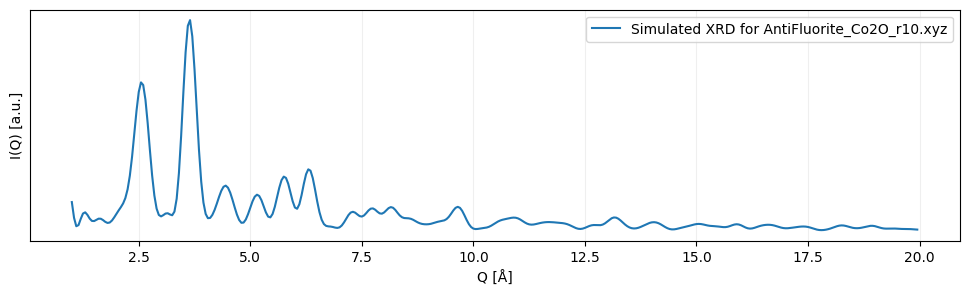

In [3]:
# Generate
calc = DebyeCalculator(qmin=1.0, qmax=20.0, qstep=0.05, qdamp=0.0, biso=0.0)
path_to_xyz_file = "data/AntiFluorite_Co2O_r10.xyz"
q, iq = calc.iq(path_to_xyz_file)

# Plot
fig, ax = plt.subplots(figsize=(12,3))
ax.plot(q, iq, label=f"Simulated XRD for {path_to_xyz_file.split('/')[-1]}")
ax.set(xlabel='Q [Å]', ylabel='I(Q) [a.u.]', yticks=[])
ax.grid(alpha=0.2)
ax.legend()
plt.show()

##### Let's try to compare the pattern generated from x-rays and neutrons:
The parameters can be changed on the fly using the build-in ``update_parameters`` method

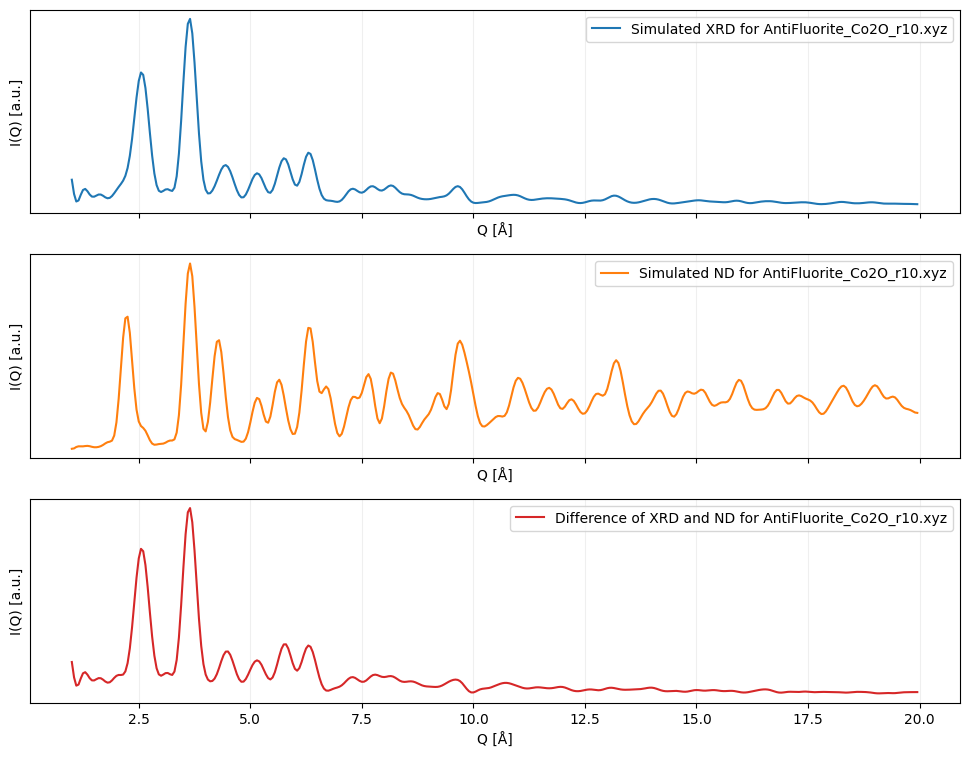

In [4]:
# Make instance (again for the sake of example)
calc = DebyeCalculator(qmin=1.0, qmax=20.0, qstep=0.05, qdamp=0.0, biso=0.15)
path_to_xyz_file = "data/AntiFluorite_Co2O_r10.xyz"

# Generate XRD
q, iq_xray = calc.iq(path_to_xyz_file)

# Update and generate ND
calc.update_parameters(rad_type='neutron')
q, iq_neu = calc.iq(path_to_xyz_file)

# Since the q-range is the same we can compare
fig, axes = plt.subplots(3,1,figsize=(12,3*3), sharex=True)
ax_xray, ax_neu, ax_diff = axes
    
ax_xray.plot(q, iq_xray, label=f"Simulated XRD for {path_to_xyz_file.split('/')[-1]}", c='#1f77b4')
ax_neu.plot(q, iq_neu, label=f"Simulated ND for {path_to_xyz_file.split('/')[-1]}", c='#ff7f0e')
ax_diff.plot(q, iq_xray-iq_neu, label=f"Difference of XRD and ND for {path_to_xyz_file.split('/')[-1]}", c='#d62728')

for ax in axes:
    ax.set(xlabel='Q [Å]', ylabel='I(Q) [a.u.]', yticks=[])
    ax.grid(alpha=0.2)
    ax.legend()
    
plt.show()

---
## Generating total scattering from `.cif`-files

The `iq` method can also be used to generate a spherical particle from a `.cif`-file based on specific radii and subsequently generate scattering intensities for every particle in the set, at the specified Q values:

```python
# Create an instance of DebyeCalculator with appropriate parameters
calc = DebyeCalculator(qmin=1.0, qmax=30.0, qdamp=0.0)

# Load a .cif-file and generate I(Q) from different sizes spherical particles
# (replace "path/to/crystalfile.cif" with your file path)
(q, iq_5), (q, iq_10) = calculator.iq(structure_path = "path/to/crystalfile.cif", radii = [5.0, 10.0])

```

##### Let's do it in practice and plot it!

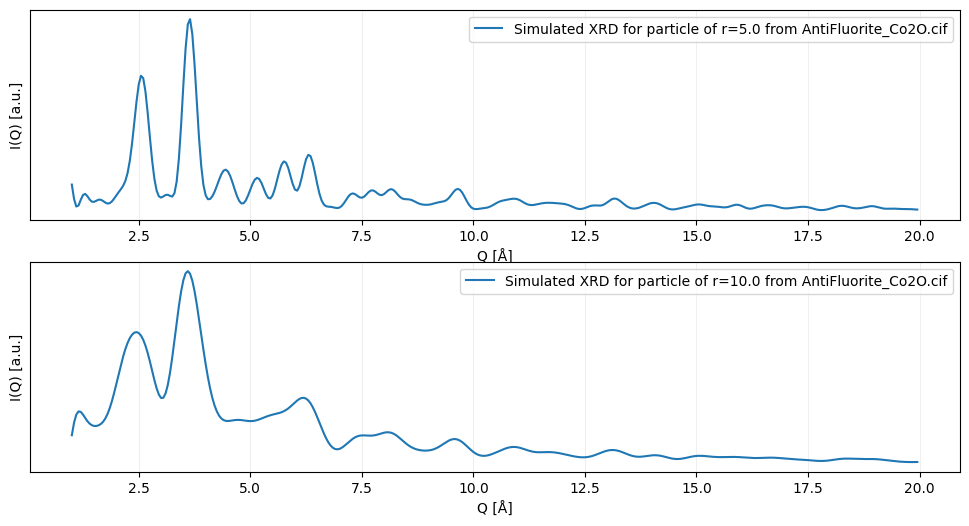

In [5]:
# Generate
calc = DebyeCalculator(qmin=1.0, qmax=20.0, qstep=0.05, qdamp=0.0, biso=0.0)
path_to_xyz_file = "data/AntiFluorite_Co2O.cif"
radii = [5.0, 10.0] # Å
(q, iq_5), (q, iq_10) = calc.iq(path_to_xyz_file, radii)

# Plot
fig, axes = plt.subplots(2,1,figsize=(12,6))
ax_5, ax_10 = axes

ax_5.plot(q, iq_5, label=f"Simulated XRD for particle of r={radii[0]} from {path_to_xyz_file.split('/')[-1]}")
ax_10.plot(q, iq_10, label=f"Simulated XRD for particle of r={radii[1]} from {path_to_xyz_file.split('/')[-1]}")

for ax in axes:
    ax.set(xlabel='Q [Å]', ylabel='I(Q) [a.u.]', yticks=[])
    ax.grid(alpha=0.2)
    ax.legend()
    
plt.show()

##### Let's see the size dependence on the PDF in action

In [18]:
# Generate
calc = DebyeCalculator(rmin=1.0, rmax=30.0)
path_to_xyz_file = "data/AntiFluorite_Co2O.cif"

N = 10
radii = np.linspace(5.0, 20.0, N) # Å
output = calc.gr(path_to_xyz_file, list(radii))

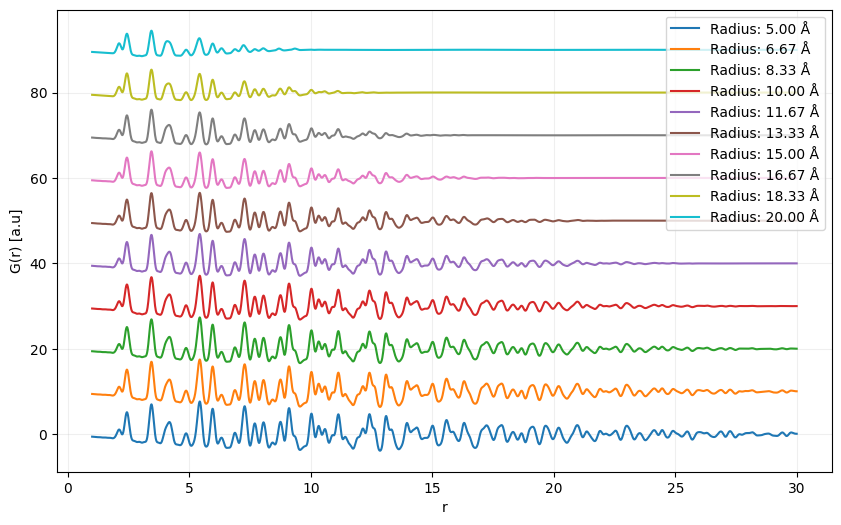

In [20]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

for i, (x, y) in enumerate(output):
    ax.plot(x, y + i*10, label=f'Radius: {radii[i]:.2f} Å')

ax.set(xlabel = 'r', ylabel = 'G(r) [a.u]')
ax.grid(alpha=0.2)
ax.legend(loc='upper right')
plt.show()